# Imports and Functions

In [1]:
import math 
from sklearn.neural_network import MLPClassifier

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton
import matplotlib.path as path
from matplotlib.colors import ListedColormap
import numpy as np
from numpy import load
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KDTree
%matplotlib notebook

global selection_model
global threshold
threshold = 20 #300 works
import random
from random import randint

global cm
global cm_bright
global wales
global maxiter
global numcoords
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

wales = load('walesoutline1.npy')
wales = path.Path(wales)


maxiter = 21
numcoords = 2
selection_model = 0 #0 for 0.5, 1 for isolated, 2 for random, 3 for best

In [2]:
import math
def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [3]:
def xnew(x): 
    return (-5)+(((x+5)*(10+5))/(51+5))
def ynew(y): 
    return ((y+2)*(15))/(55)

def branin(x, a=1, b=5.1/(4*(np.pi**2)), c=5/np.pi, r=6, s=10, t=1/(8*np.pi), noise=0.1):
       
    return a*(x[1]-(b*(x[0]**2))+c*x[0]-r)**2+(s*(1-t)*np.cos(x[0]))+s

def braninColor(x, threshold):
    
    if branin((xnew(x[0]),xnew(x[1])))>threshold:
        return 1
    else:
        return 0   

In [4]:
def calculateModel():
    
    global X
    global Z
    global Z_model_pred
    global Znew
    global ZBranin
    global xx,yy
    global Big_df
    global Big_df_land


    x_min, x_max = -5, 51 
    y_min, y_max = -2, 53
    h = .5  # step size in the mesh

    Coords_df = pd.DataFrame(coords,columns=['XPos','YPos','Type'])
    DT_X_Values = Coords_df.drop(['Type'],axis=1)

    X = DT_X_Values.to_numpy().tolist()
    X = np.array(X)

    DT_Y_Values = Coords_df.drop(['XPos'],axis=1)
    DT_Y_Values = DT_Y_Values.drop(['YPos'],axis=1)
    y = DT_Y_Values.to_numpy().ravel()



    clf = MLPClassifier(alpha=0.3, max_iter=3000, solver = 'lbfgs')
    clf.fit(X, y)
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
    
    ZBranin = []
    branincoords = np.c_[xx.ravel(), yy.ravel()]
    for i in range(12320):
        ZBranin.append(braninColor(branincoords[i],20))



    Z_model_prob = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z_model_prob = Z_model_prob.reshape(xx.shape)                                                      #Z is [model_probs]
    Z_model_pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])[:]                        #Z_model_pred is [model_predictions]

    Big_df = pd.DataFrame(xx.ravel(), columns=['xx'])#
    Big_df.insert(1, 'yy',yy.ravel())
    Big_df.insert(2, 'Z_model_predictions', Z_model_pred.ravel())
    Big_df.insert(3, 'Z_model_predictions_flattened', 0)
    Big_df.insert(4, 'Z_model_probs', Z_model_prob.ravel())
    Big_df.insert(5, 'Z_model_probs_flattened_SEA', 0)
    Big_df.insert(6, 'Z_model_probs_flattened_0', 0)
    Big_df.insert(7, 'Surrogate_model_predictions', ZBranin)
    Big_df.insert(8, 'Surrogate_model_predictions_flattened', 0)

    for i in range(12320):

        if (wales.contains_points([(Big_df.iat[i,0],Big_df.iat[i,1])])[0]):
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_probs']
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = Big_df.iloc[i]['Surrogate_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = Big_df.iloc[i]['Z_model_probs']

        else:
            Big_df.loc[i, 'Z_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = 'SEA'
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = 0

    Z_model_predictions = Big_df["Z_model_predictions"].to_numpy()
    Z_model_predictions_flattened = Big_df["Z_model_predictions_flattened"].to_numpy()
    Z_model_probs = Big_df["Z_model_probs"].to_numpy()
#     Z_model_probs_flattened = Big_df["Z_model_probs_flattened"].to_numpy()
    Surrogate_model_predictions = Big_df["Surrogate_model_predictions"].to_numpy()
    Surrogate_model_predictions_flattened = Big_df["Surrogate_model_predictions_flattened"].to_numpy()

    Big_df_land = Big_df[Big_df['Z_model_predictions_flattened'] != 'SEA']

    Contour_model = Big_df["Z_model_probs_flattened_0"].to_numpy()
    Contour_model = Contour_model.reshape(xx.shape) 


    plt.cla()
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic_r')
    # plt.axis("off")
    plt.grid()
    ax.contourf(xx, yy, Contour_model, 40, cmap=cm, alpha=
                0.4)

    plt.plot()

    plt.show()


In [5]:
def find_isolated_point():
       
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]

    testpoints = tmp_df[['xx','yy']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        if dist>maxdist:
            maxdist = dist
            maxind = ind
            ifinal = i

#     ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)
#     plt.plot()
#     plt.show()
#     fig1.show()
    print('isolated', testpoints[ifinal])
#     return testpoints[ifinal]
    
def find0_5():
    
    tmp_df = Big_df.iloc[(Big_df['Z_model_probs_flattened_0']-0.50).abs().argsort()[:2]]
    value = randint(0, len(tmp_df.index)-1)
    uncertain_coord = [tmp_df.iloc[value]['xx'],tmp_df.iloc[value]['yy']]
        
    ax.scatter(uncertain_coord[0], uncertain_coord[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()    
    fig1.show()
      
#     print('0_5', uncertain_coord)
    return uncertain_coord

def random_point():
    
    tmp_df = Big_df_land.iloc[::5, :]
    testpoints = tmp_df[['xx','yy']].to_numpy()
                    
    ifinal = randint(0,len(testpoints.tolist()))
    
    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()
    
    fig1.show()
    
    return testpoints[ifinal]

def best():
    
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]
    score = 0

    testpoints = tmp_df[['xx','yy']].to_numpy()
    testpoints1 = tmp_df[['Z_model_probs']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        prob = testpoints1[i]
        tmp_score = dist*normpdf(prob,0.5,0.05)
        if tmp_score>score:
            ifinal = i
            distfinal = dist
            probfinal = prob
            score = tmp_score

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()

    fig1.show()
    
    find0_5()
    find_isolated_point()
    
    print(distfinal)
    print(probfinal)
    print(score)
    print('best',testpoints[ifinal])

    return testpoints[ifinal]
    
    



In [6]:
def Accuracy():
    
    correctPredictions = 0
    incorrectPredictions = 0

    for i in range(len(Big_df_land.index)):
        if ((Big_df_land.iloc[i]["Z_model_predictions"])==(Big_df_land.iloc[i]["Surrogate_model_predictions"])):
            correctPredictions+=1
        else:
            incorrectPredictions+=1


    accuracy = (correctPredictions)/((
    incorrectPredictions+correctPredictions))
    accuracyArray.append(accuracy)

    print('Accuracy is',accuracy)
    

def printGraph():
    
    xAxis = []
    for i in range(len(accuracyArray)):
        xAxis.append(i+1)

    plt.scatter(xAxis, accuracyArray) 
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy over time')
    plt.ylim(0.3, 1.0)  
    plt.show()

# Plot first graph

experiment:  0


<IPython.core.display.Javascript object>


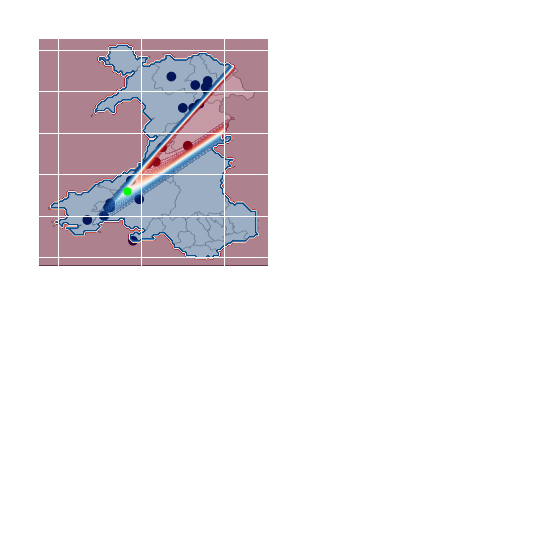

iteration  1
Accuracy is 0.5637377427417805
iteration  2
Accuracy is 0.5816189194385695
iteration  3
Accuracy is 0.6083445491251682
iteration  4
Accuracy is 0.588925206691021
iteration  5
Accuracy is 0.5918092674485675
iteration  6
Accuracy is 0.5852720630647952
iteration  7
Accuracy is 0.5810421072870602
iteration  8
Accuracy is 0.5846952509132859
iteration  9
Accuracy is 0.5873870409536628
iteration  10
Accuracy is 0.588925206691021
iteration  11
Accuracy is 0.5898865602768698
iteration  12
Accuracy is 0.5920015381657373
iteration  13
Accuracy is 0.5939242453374352
iteration  14
Accuracy is 0.5964237646606422
iteration  15
Accuracy is 0.5995000961353586
iteration  16
Accuracy is 0.5979619303980004
iteration  17
Accuracy is 0.6098827148625264
iteration  18
Accuracy is 0.6271870794078062
iteration  19
Accuracy is 0.6990963276293021
iteration  20
Accuracy is 0.5858488752163046
iteration  21
Accuracy is 0.5841184387617766
experiment:  1


<IPython.core.display.Javascript object>


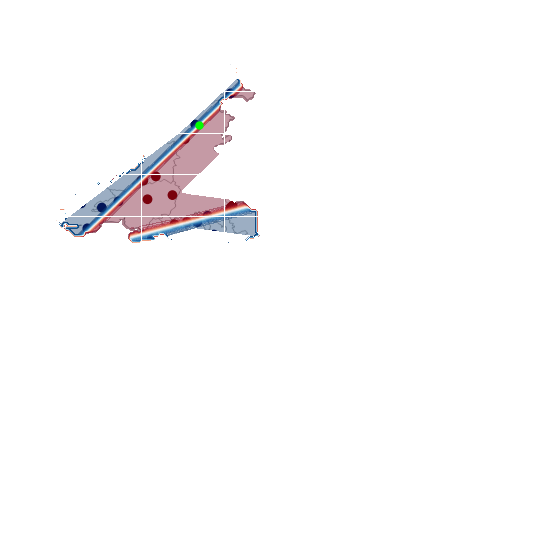

iteration  1
Accuracy is 0.4445298980965199
iteration  2
Accuracy is 0.4908671409344357
iteration  3
Accuracy is 0.5652759084791387
iteration  4
Accuracy is 0.5302826379542396
iteration  5
Accuracy is 0.6664103057104404
iteration  6
Accuracy is 0.6875600845991156
iteration  7
Accuracy is 0.7094789463564699
iteration  8
Accuracy is 0.702557200538358
iteration  9
Accuracy is 0.6833301288213806
iteration  10
Accuracy is 0.6925591232455297
iteration  11
Accuracy is 0.6865987310132666
iteration  12
Accuracy is 0.685445106710248
iteration  13
Accuracy is 0.685445106710248
iteration  14
Accuracy is 0.6890982503364738
iteration  15
Accuracy is 0.6877523553162853
iteration  16
Accuracy is 0.6879446260334551
iteration  17
Accuracy is 0.6867910017304365
iteration  18
Accuracy is 0.6894827917708133
iteration  19
Accuracy is 0.6917900403768507
iteration  20
Accuracy is 0.6917900403768507
iteration  21
Accuracy is 0.6881368967506248
experiment:  2


<IPython.core.display.Javascript object>


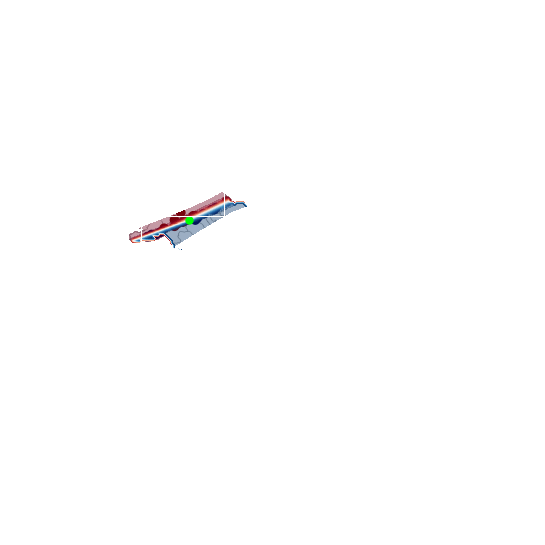

iteration  1
Accuracy is 0.44549125168236875
iteration  2
Accuracy is 0.4445298980965199
iteration  3
Accuracy is 0.4420303787733128
iteration  4
Accuracy is 0.44414535666218036
iteration  5
Accuracy is 0.4429917323591617
iteration  6
Accuracy is 0.44491443953085946
iteration  7
Accuracy is 0.44183810805614304
iteration  8
Accuracy is 0.4422226494904826
iteration  9
Accuracy is 0.4414535666218035
iteration  10
Accuracy is 0.4414535666218035
iteration  11
Accuracy is 0.44106902518746394
iteration  12
Accuracy is 0.4414535666218035
iteration  13
Accuracy is 0.44106902518746394
iteration  14
Accuracy is 0.4416458373389733
iteration  15
Accuracy is 0.4420303787733128
iteration  16
Accuracy is 0.4414535666218035
iteration  17
Accuracy is 0.44183810805614304
iteration  18
Accuracy is 0.4422226494904826
iteration  19
Accuracy is 0.44337627379350125
iteration  20
Accuracy is 0.4427994616419919
iteration  21
Accuracy is 0.44337627379350125
experiment:  3


<IPython.core.display.Javascript object>


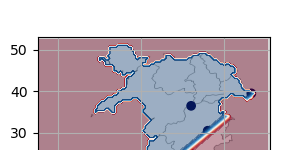

iteration  1
Accuracy is 0.5466256489136705
iteration  2
Accuracy is 0.6414151124783696
iteration  3
Accuracy is 0.5962314939434724
iteration  4
Accuracy is 0.565852720630648
iteration  5
Accuracy is 0.6218034993270525
iteration  6
Accuracy is 0.6323783887713901
iteration  7
Accuracy is 0.6400692174581811
iteration  8
Accuracy is 0.6396846760238416
iteration  9
Accuracy is 0.6408383003268602
iteration  10
Accuracy is 0.650451836185349
iteration  11
Accuracy is 0.6629494328013843
iteration  12
Accuracy is 0.662372620649875
iteration  13
Accuracy is 0.6858296481445876
iteration  14
Accuracy is 0.6677562007306287
iteration  15
Accuracy is 0.6731397808113824
iteration  16
Accuracy is 0.6865987310132666
iteration  17
Accuracy is 0.6815996923668526
iteration  18
Accuracy is 0.7404345318208037
iteration  19
Accuracy is 0.690636416073832
iteration  20
Accuracy is 0.6823687752355316
iteration  21
Accuracy is 0.6927513939626995
experiment:  4


<IPython.core.display.Javascript object>


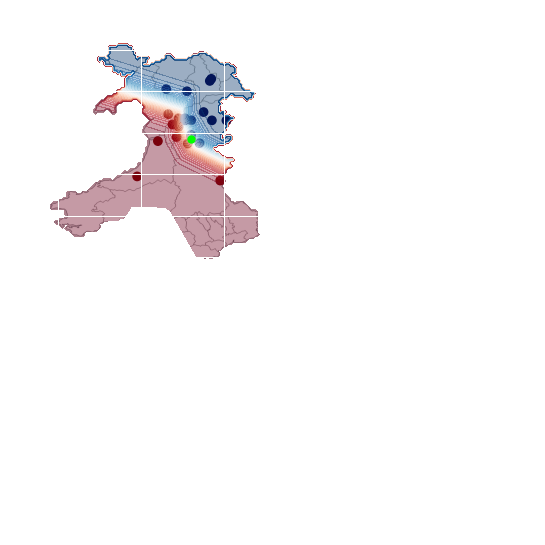

iteration  1
Accuracy is 0.6064218419534705
iteration  2
Accuracy is 0.548740626802538
iteration  3
Accuracy is 0.56412228417612
iteration  4
Accuracy is 0.5270140357623534
iteration  5
Accuracy is 0.5677754278023457
iteration  6
Accuracy is 0.5573928090751779
iteration  7
Accuracy is 0.5572005383580081
iteration  8
Accuracy is 0.5485483560853682
iteration  9
Accuracy is 0.6314170351855413
iteration  10
Accuracy is 0.5929628917515862
iteration  11
Accuracy is 0.6002691790040376
iteration  12
Accuracy is 0.6046914054989425
iteration  13
Accuracy is 0.608536819842338
iteration  14
Accuracy is 0.6237262064987502
iteration  15
Accuracy is 0.6106517977312056
iteration  16
Accuracy is 0.6081522784079985
iteration  17
Accuracy is 0.6152662949432801
iteration  18
Accuracy is 0.6266102672562969
iteration  19
Accuracy is 0.6346856373774274
iteration  20
Accuracy is 0.6662180349932705
iteration  21
Accuracy is 0.6783310901749664
experiment:  5


<IPython.core.display.Javascript object>


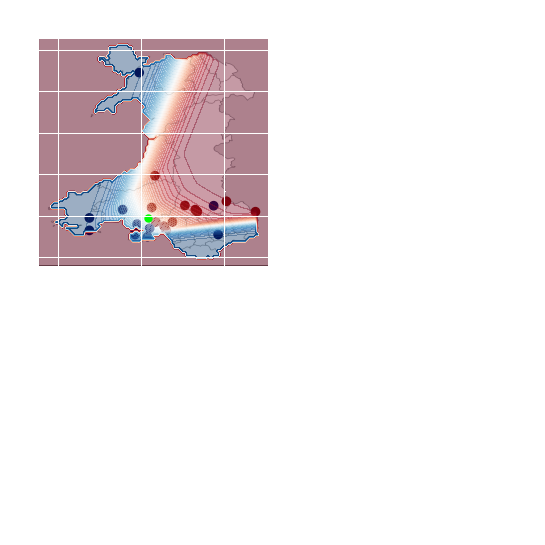

iteration  1
Accuracy is 0.3851182464910594
iteration  2
Accuracy is 0.5004806767929244
iteration  3
Accuracy is 0.43856950586425686
iteration  4
Accuracy is 0.4406844837531244
iteration  5
Accuracy is 0.44049221303595465
iteration  6
Accuracy is 0.38492597577388965
iteration  7
Accuracy is 0.38492597577388965
iteration  8
Accuracy is 0.38492597577388965
iteration  9
Accuracy is 0.38569505864256876
iteration  10
Accuracy is 0.38492597577388965
iteration  11
Accuracy is 0.38742549509709673
iteration  12
Accuracy is 0.3860796000769083
iteration  13
Accuracy is 0.3960776773697366
iteration  14
Accuracy is 0.4276100749855797
iteration  15
Accuracy is 0.4952893674293405
iteration  16
Accuracy is 0.5525860411459335
iteration  17
Accuracy is 0.5689290521053644
iteration  18
Accuracy is 0.6054604883676216
iteration  19
Accuracy is 0.6346856373774274
iteration  20
Accuracy is 0.645260526821765
iteration  21
Accuracy is 0.6633339742357239
experiment:  6


<IPython.core.display.Javascript object>


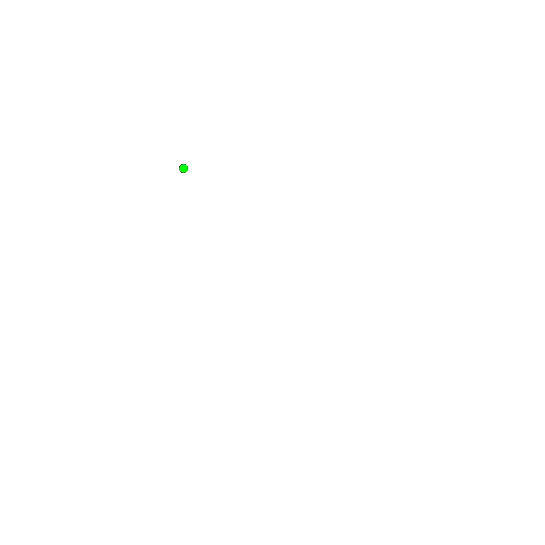

iteration  1
Accuracy is 0.5572005383580081
iteration  2
Accuracy is 0.5956546817919631
iteration  3
Accuracy is 0.634108825225918
iteration  4
Accuracy is 0.6429532782157278
iteration  5
Accuracy is 0.6394924053066718
iteration  6
Accuracy is 0.6410305710440299
iteration  7
Accuracy is 0.6419919246298789
iteration  8
Accuracy is 0.6431455489328975
iteration  9
Accuracy is 0.6429532782157278
iteration  10
Accuracy is 0.6431455489328975
iteration  11
Accuracy is 0.6433378196500673
iteration  12
Accuracy is 0.6431455489328975
iteration  13
Accuracy is 0.6433378196500673
iteration  14
Accuracy is 0.6439146318015766
iteration  15
Accuracy is 0.642761007498558
iteration  16
Accuracy is 0.6431455489328975
iteration  17
Accuracy is 0.6431455489328975
iteration  18
Accuracy is 0.6437223610844068
iteration  19
Accuracy is 0.6431455489328975
iteration  20
Accuracy is 0.6433378196500673
iteration  21
Accuracy is 0.6433378196500673
experiment:  7


<IPython.core.display.Javascript object>


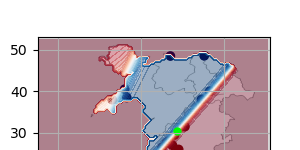

iteration  1
Accuracy is 0.635070178811767
iteration  2
Accuracy is 0.4699096327629302
iteration  3
Accuracy is 0.5233608921361277
iteration  4
Accuracy is 0.5600845991155547
iteration  5
Accuracy is 0.5696981349740434
iteration  6
Accuracy is 0.5577773505095174
iteration  7
Accuracy is 0.5500865218227264
iteration  8
Accuracy is 0.5673908863680062
iteration  9
Accuracy is 0.5691213228225341
iteration  10
Accuracy is 0.562391847721592
iteration  11
Accuracy is 0.5789271293981927
iteration  12
Accuracy is 0.5748894443376273
iteration  13
Accuracy is 0.5775812343780042
iteration  14
Accuracy is 0.5814266487213997
iteration  15
Accuracy is 0.5796962122668717
iteration  16
Accuracy is 0.58123437800423
iteration  17
Accuracy is 0.5762353393578158
iteration  18
Accuracy is 0.5775812343780042
iteration  19
Accuracy is 0.5806575658527207
iteration  20
Accuracy is 0.5950778696404537
iteration  21
Accuracy is 0.579503941549702
experiment:  8


<IPython.core.display.Javascript object>


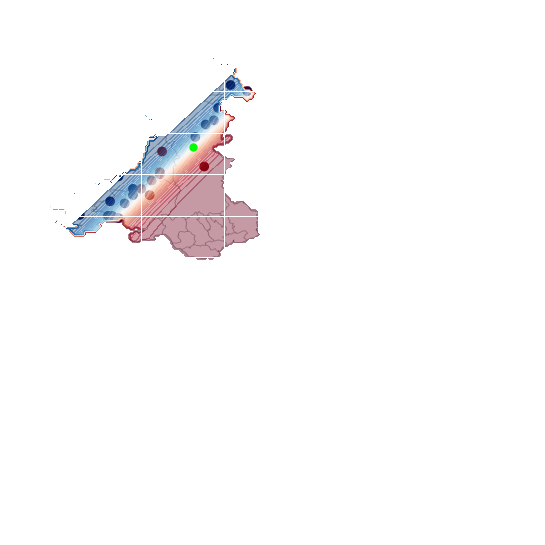

iteration  1
Accuracy is 0.5510478754085752
iteration  2
Accuracy is 0.4726014228033071
iteration  3
Accuracy is 0.5141318977119784
iteration  4
Accuracy is 0.6191117092866757
iteration  5
Accuracy is 0.6281484329936551
iteration  6
Accuracy is 0.6337242837915785
iteration  7
Accuracy is 0.6331474716400692
iteration  8
Accuracy is 0.6356469909632763
iteration  9
Accuracy is 0.6400692174581811
iteration  10
Accuracy is 0.6369928859834647
iteration  11
Accuracy is 0.6373774274178042
iteration  12
Accuracy is 0.636800615266295
iteration  13
Accuracy is 0.6381465102864834
iteration  14
Accuracy is 0.6400692174581811
iteration  15
Accuracy is 0.6369928859834647
iteration  16
Accuracy is 0.639300134589502
iteration  17
Accuracy is 0.6387233224379927
iteration  18
Accuracy is 0.6460296096904441
iteration  19
Accuracy is 0.6802537973466641
iteration  20
Accuracy is 0.7425495097096713
iteration  21
Accuracy is 0.6423764660642184
experiment:  9


<IPython.core.display.Javascript object>


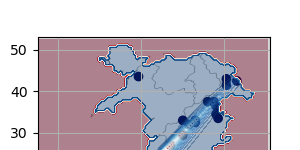

iteration  1
Accuracy is 0.5933474331859258
iteration  2
Accuracy is 0.5998846375696981
iteration  3
Accuracy is 0.6029609690444145
iteration  4
Accuracy is 0.6077677369736589
iteration  5
Accuracy is 0.6027686983272448
iteration  6
Accuracy is 0.6046914054989425
iteration  7
Accuracy is 0.6087290905595077
iteration  8
Accuracy is 0.6081522784079985
iteration  9
Accuracy is 0.6121899634685637
iteration  10
Accuracy is 0.6137281292059219
iteration  11
Accuracy is 0.6110363391655451
iteration  12
Accuracy is 0.610267256296866
iteration  13
Accuracy is 0.610267256296866
iteration  14
Accuracy is 0.6110363391655451
iteration  15
Accuracy is 0.6135358584887521
iteration  16
Accuracy is 0.6154585656604499
iteration  17
Accuracy is 0.6146894827917708
iteration  18
Accuracy is 0.6248798308017689
iteration  19
Accuracy is 0.6366083445491252
iteration  20
Accuracy is 0.634108825225918
iteration  21
Accuracy is 0.5993078254181888
experiment:  10


<IPython.core.display.Javascript object>


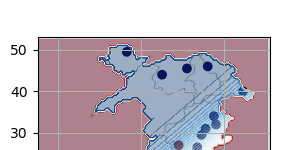

iteration  1
Accuracy is 0.5612382234185733
iteration  2
Accuracy is 0.545279753893482
iteration  3
Accuracy is 0.5621995770044222
iteration  4
Accuracy is 0.5754662564891367
iteration  5
Accuracy is 0.5598923283983849
iteration  6
Accuracy is 0.5808498365698904
iteration  7
Accuracy is 0.6369928859834647
iteration  8
Accuracy is 0.7365891174774082
iteration  9
Accuracy is 0.6423764660642184
iteration  10
Accuracy is 0.6560276869832724
iteration  11
Accuracy is 0.6383387810036532
iteration  12
Accuracy is 0.6404537588925207
iteration  13
Accuracy is 0.6556431455489329
iteration  14
Accuracy is 0.6421841953470486
iteration  15
Accuracy is 0.646990963276293
iteration  16
Accuracy is 0.6421841953470486
iteration  17
Accuracy is 0.6421841953470486
iteration  18
Accuracy is 0.6477600461449721
iteration  19
Accuracy is 0.6477600461449721
iteration  20
Accuracy is 0.650451836185349
iteration  21
Accuracy is 0.636800615266295
experiment:  11


<IPython.core.display.Javascript object>


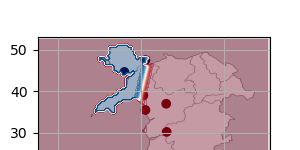

iteration  1
Accuracy is 0.4822149586617958
iteration  2
Accuracy is 0.5491251682368775
iteration  3
Accuracy is 0.5314362622572583
iteration  4
Accuracy is 0.5781580465295135
iteration  5
Accuracy is 0.5720053835800808
iteration  6
Accuracy is 0.6033455104787541
iteration  7
Accuracy is 0.585464333781965
iteration  8
Accuracy is 0.6371851567006345
iteration  9
Accuracy is 0.5825802730244184
iteration  10
Accuracy is 0.5497019803883868
iteration  11
Accuracy is 0.5143241684291482
iteration  12
Accuracy is 0.5629686598731013
iteration  13
Accuracy is 0.5745049029032878
iteration  14
Accuracy is 0.6139203999230917
iteration  15
Accuracy is 0.6289175158623341
iteration  16
Accuracy is 0.6346856373774274
iteration  17
Accuracy is 0.6421841953470486
iteration  18
Accuracy is 0.6198807921553547
iteration  19
Accuracy is 0.6091136319938474
iteration  20
Accuracy is 0.6275716208421458
iteration  21
Accuracy is 0.639300134589502
experiment:  12


<IPython.core.display.Javascript object>


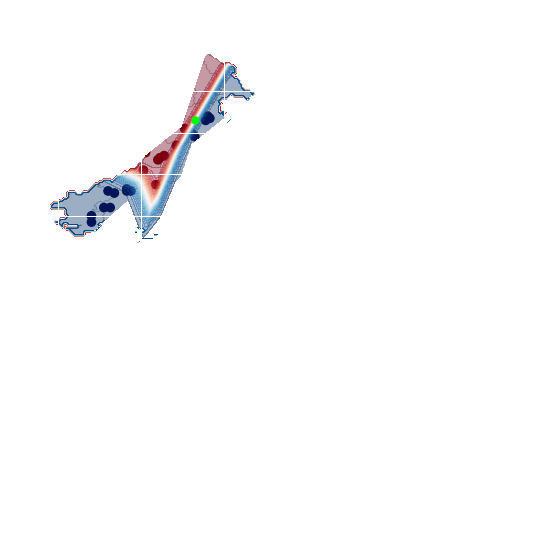

iteration  1
Accuracy is 0.3935781580465295
iteration  2
Accuracy is 0.3758892520669102
iteration  3
Accuracy is 0.37089021342049605
iteration  4
Accuracy is 0.3762737935012498
iteration  5
Accuracy is 0.37608152278407997
iteration  6
Accuracy is 0.3812728321476639
iteration  7
Accuracy is 0.382041915016343
iteration  8
Accuracy is 0.38415689290521055
iteration  9
Accuracy is 0.3799269371274755
iteration  10
Accuracy is 0.37858104210728705
iteration  11
Accuracy is 0.380311478561815
iteration  12
Accuracy is 0.382041915016343
iteration  13
Accuracy is 0.38550278792539894
iteration  14
Accuracy is 0.3887713901172851
iteration  15
Accuracy is 0.39396269948086904
iteration  16
Accuracy is 0.39261680446068065
iteration  17
Accuracy is 0.42203422418765624
iteration  18
Accuracy is 0.39396269948086904
iteration  19
Accuracy is 0.44010767160161507
iteration  20
Accuracy is 0.5818111901557392
iteration  21
Accuracy is 0.5570082676408383
experiment:  13


<IPython.core.display.Javascript object>


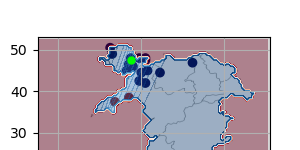

iteration  1
Accuracy is 0.5200922899442415
iteration  2
Accuracy is 0.5520092289944242
iteration  3
Accuracy is 0.5527783118631032
iteration  4
Accuracy is 0.5746971736204576
iteration  5
Accuracy is 0.5646990963276293
iteration  6
Accuracy is 0.5668140742164969
iteration  7
Accuracy is 0.5698904056912132
iteration  8
Accuracy is 0.5729667371659296
iteration  9
Accuracy is 0.5750817150547971
iteration  10
Accuracy is 0.5775812343780042
iteration  11
Accuracy is 0.5904633724283792
iteration  12
Accuracy is 0.593155162468756
iteration  13
Accuracy is 0.6121899634685637
iteration  14
Accuracy is 0.6150740242261103
iteration  15
Accuracy is 0.6150740242261103
iteration  16
Accuracy is 0.6150740242261103
iteration  17
Accuracy is 0.6150740242261103
iteration  18
Accuracy is 0.6150740242261103
iteration  19
Accuracy is 0.6150740242261103
iteration  20
Accuracy is 0.6150740242261103
iteration  21
Accuracy is 0.6150740242261103
experiment:  14


<IPython.core.display.Javascript object>


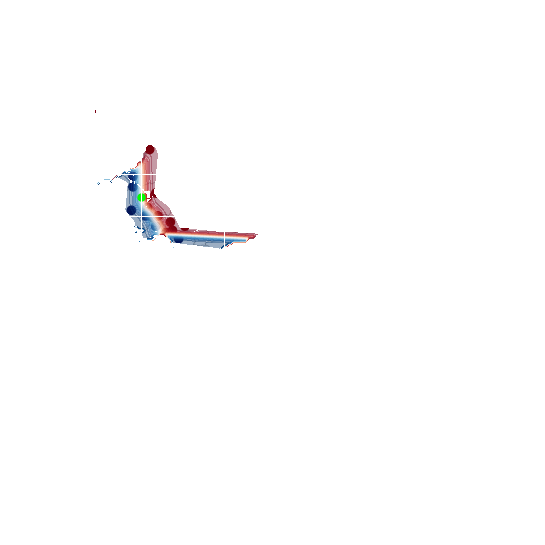

iteration  1
Accuracy is 0.4226110363391655
iteration  2
Accuracy is 0.5310517208229186
iteration  3
Accuracy is 0.3335896942895597
iteration  4
Accuracy is 0.5566237262064988
iteration  5
Accuracy is 0.5468179196308403
iteration  6
Accuracy is 0.5572005383580081
iteration  7
Accuracy is 0.5585464333781965
iteration  8
Accuracy is 0.5500865218227264
iteration  9
Accuracy is 0.5791194001153624
iteration  10
Accuracy is 0.5960392232263027
iteration  11
Accuracy is 0.5937319746202653
iteration  12
Accuracy is 0.5818111901557392
iteration  13
Accuracy is 0.5921938088829072
iteration  14
Accuracy is 0.5935397039030955
iteration  15
Accuracy is 0.5873870409536628
iteration  16
Accuracy is 0.5977696596808306
iteration  17
Accuracy is 0.6037300519130936
iteration  18
Accuracy is 0.5825802730244184
iteration  19
Accuracy is 0.5887329359738512
iteration  20
Accuracy is 0.5920015381657373
iteration  21
Accuracy is 0.6010382618727168
experiment:  15


<IPython.core.display.Javascript object>


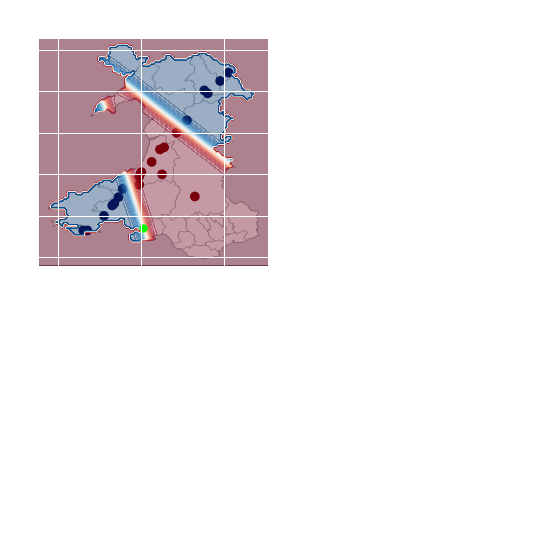

iteration  1
Accuracy is 0.6412228417611998
iteration  2
Accuracy is 0.6133435877715824
iteration  3
Accuracy is 0.6200730628725245
iteration  4
Accuracy is 0.606037300519131
iteration  5
Accuracy is 0.5964237646606422
iteration  6
Accuracy is 0.6023841568929053
iteration  7
Accuracy is 0.6031532397615843
iteration  8
Accuracy is 0.6056527590847914
iteration  9
Accuracy is 0.6021918861757354
iteration  10
Accuracy is 0.6039223226302635
iteration  11
Accuracy is 0.602576427610075
iteration  12
Accuracy is 0.6031532397615843
iteration  13
Accuracy is 0.6039223226302635
iteration  14
Accuracy is 0.6054604883676216
iteration  15
Accuracy is 0.6052682176504518
iteration  16
Accuracy is 0.6250721015189387
iteration  17
Accuracy is 0.6073831955393194
iteration  18
Accuracy is 0.8040761392039992
iteration  19
Accuracy is 0.6071909248221495
iteration  20
Accuracy is 0.6135358584887521
iteration  21
Accuracy is 0.8015766198807922
experiment:  16


<IPython.core.display.Javascript object>


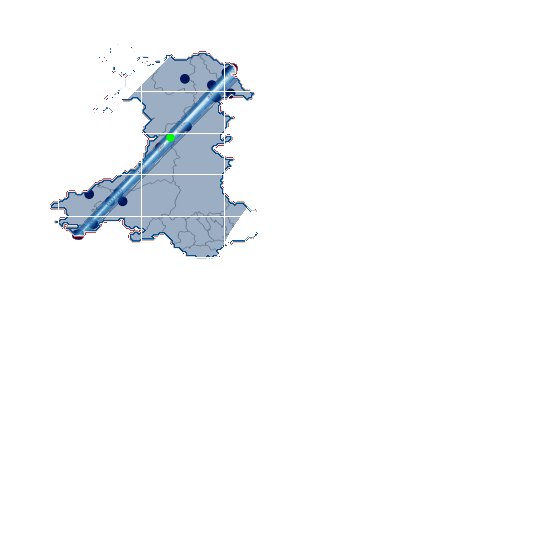

iteration  1
Accuracy is 0.5010574889444338
iteration  2
Accuracy is 0.5337435108632955
iteration  3
Accuracy is 0.5637377427417805
iteration  4
Accuracy is 0.565852720630648
iteration  5
Accuracy is 0.6150740242261103
iteration  6
Accuracy is 0.6150740242261103
iteration  7
Accuracy is 0.6150740242261103
iteration  8
Accuracy is 0.6150740242261103
iteration  9
Accuracy is 0.6150740242261103
iteration  10
Accuracy is 0.6150740242261103
iteration  11
Accuracy is 0.6150740242261103
iteration  12
Accuracy is 0.6150740242261103
iteration  13
Accuracy is 0.6160353778119593
iteration  14
Accuracy is 0.6069986541049798
iteration  15
Accuracy is 0.6148817535089406
iteration  16
Accuracy is 0.5962314939434724
iteration  17
Accuracy is 0.6116131513170544
iteration  18
Accuracy is 0.6150740242261103
iteration  19
Accuracy is 0.6119976927513939
iteration  20
Accuracy is 0.6150740242261103
iteration  21
Accuracy is 0.6154585656604499
experiment:  17


<IPython.core.display.Javascript object>


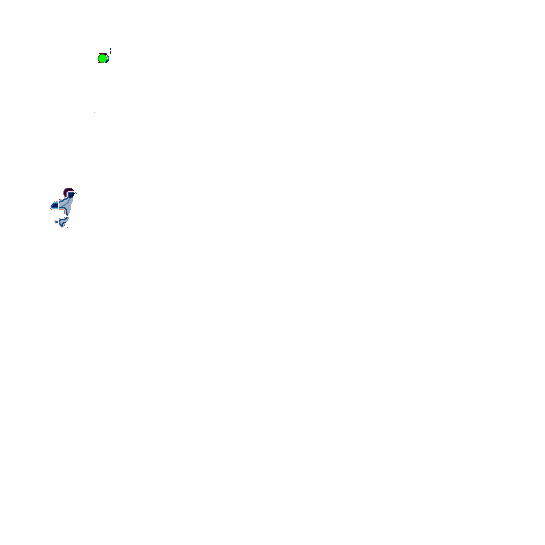

iteration  1
Accuracy is 0.5427802345702749
iteration  2
Accuracy is 0.58123437800423
iteration  3
Accuracy is 0.6021918861757354
iteration  4
Accuracy is 0.5998846375696981
iteration  5
Accuracy is 0.6121899634685637
iteration  6
Accuracy is 0.6152662949432801
iteration  7
Accuracy is 0.6156508363776196
iteration  8
Accuracy is 0.6152662949432801
iteration  9
Accuracy is 0.6154585656604499
iteration  10
Accuracy is 0.6156508363776196
iteration  11
Accuracy is 0.6156508363776196
iteration  12
Accuracy is 0.6156508363776196
iteration  13
Accuracy is 0.6156508363776196
iteration  14
Accuracy is 0.6156508363776196
iteration  15
Accuracy is 0.6156508363776196
iteration  16
Accuracy is 0.6156508363776196
iteration  17
Accuracy is 0.6156508363776196
iteration  18
Accuracy is 0.6156508363776196
iteration  19
Accuracy is 0.6156508363776196
iteration  20
Accuracy is 0.6156508363776196
iteration  21
Accuracy is 0.6156508363776196
experiment:  18


<IPython.core.display.Javascript object>


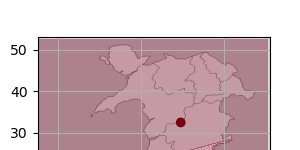

iteration  1
Accuracy is 0.39319361661219
iteration  2
Accuracy is 0.4129975004806768
iteration  3
Accuracy is 0.35320130744087674
iteration  4
Accuracy is 0.35166314170351853
iteration  5
Accuracy is 0.3574312632186118
iteration  6
Accuracy is 0.3633916554508748
iteration  7
Accuracy is 0.36781388194577963
iteration  8
Accuracy is 0.3703134012689867
iteration  9
Accuracy is 0.3768506056527591
iteration  10
Accuracy is 0.3912709094404922
iteration  11
Accuracy is 0.3972313016727552
iteration  12
Accuracy is 0.41242068832916745
iteration  13
Accuracy is 0.4064602960969044
iteration  14
Accuracy is 0.4268409921169006
iteration  15
Accuracy is 0.6652566814074217
iteration  16
Accuracy is 0.6917900403768507
iteration  17
Accuracy is 0.6466064218419535
iteration  18
Accuracy is 0.5454720246106518
iteration  19
Accuracy is 0.620457604306864
iteration  20
Accuracy is 0.4987502403383965
iteration  21
Accuracy is 0.4993270524899058
experiment:  19


<IPython.core.display.Javascript object>


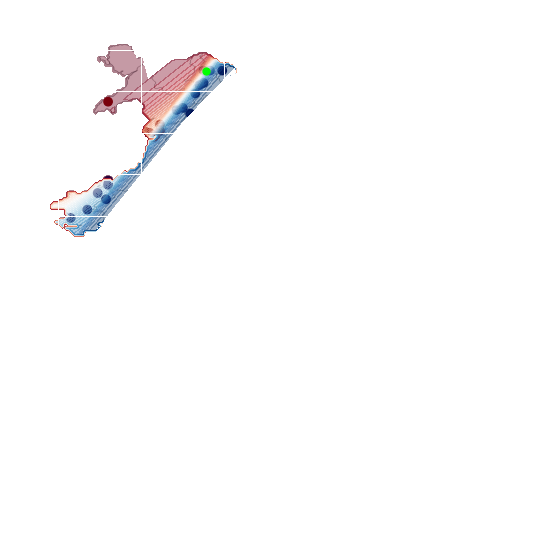

iteration  1
Accuracy is 0.44049221303595465
iteration  2
Accuracy is 0.4612574504902903
iteration  3
Accuracy is 0.47240915208613726
iteration  4
Accuracy is 0.48048452220726784
iteration  5
Accuracy is 0.5035570082676408
iteration  6
Accuracy is 0.4637569698134974
iteration  7
Accuracy is 0.4704864449144395
iteration  8
Accuracy is 0.46567967698519513
iteration  9
Accuracy is 0.4677946548740627
iteration  10
Accuracy is 0.5081715054797155
iteration  11
Accuracy is 0.5104787540857527
iteration  12
Accuracy is 0.4714477985002884
iteration  13
Accuracy is 0.47337050567198613
iteration  14
Accuracy is 0.5110555662372621
iteration  15
Accuracy is 0.47164006921745816
iteration  16
Accuracy is 0.47721592001538166
iteration  17
Accuracy is 0.5158623341665064
iteration  18
Accuracy is 0.510286483368583
iteration  19
Accuracy is 0.5122091905402807
iteration  20
Accuracy is 0.5225918092674485
iteration  21
Accuracy is 0.5039415497019804
experiment:  20


<IPython.core.display.Javascript object>


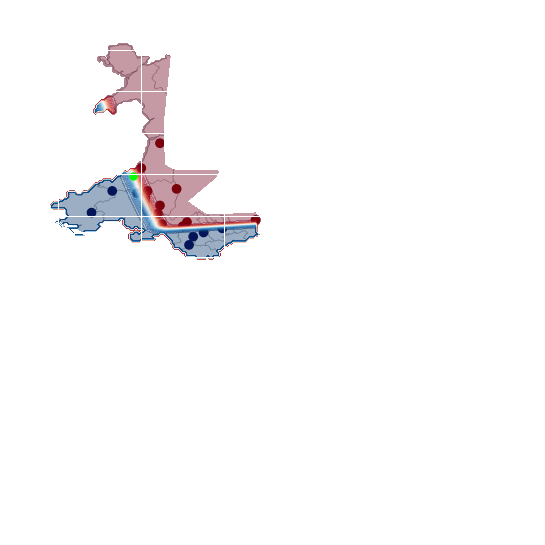

iteration  1
Accuracy is 0.5654681791963084
iteration  2
Accuracy is 0.4824072293789656
iteration  3
Accuracy is 0.5229763507017882
iteration  4
Accuracy is 0.4993270524899058
iteration  5
Accuracy is 0.5372043837723515
iteration  6
Accuracy is 0.5377811959238608
iteration  7
Accuracy is 0.5450874831763123
iteration  8
Accuracy is 0.5031724668333013
iteration  9
Accuracy is 0.5485483560853682
iteration  10
Accuracy is 0.5798884829840415
iteration  11
Accuracy is 0.5677754278023457
iteration  12
Accuracy is 0.5843107094789464
iteration  13
Accuracy is 0.5868102288021534
iteration  14
Accuracy is 0.6366083445491252
iteration  15
Accuracy is 0.6148817535089406
iteration  16
Accuracy is 0.6519900019227072
iteration  17
Accuracy is 0.5975773889636609
iteration  18
Accuracy is 0.6127667756200731
iteration  19
Accuracy is 0.6148817535089406
iteration  20
Accuracy is 0.6093059027110171
iteration  21
Accuracy is 0.616227648529129


In [7]:
from random import randint
import time

valid_seeds = [4,27,12,15,17,21,23,24,25,28,31,32,35,36,37,41,42,43,45,48,420]

Results = []

for j in range(len(valid_seeds)):
    
    random.seed(valid_seeds[j])

    print('experiment: ',j)                            

    num = 100
    x = np.linspace(-5, 51, num)
    y = np.linspace(-2, 53, num)
    global landpoints 
    landpoints = []

    for i in range(num):
        for j in range(num):
            if wales.contains_points([(x[i],y[j])]):
                landpoints.append([x[i],y[j]])

    landpoints = np.asarray(landpoints, dtype=np.float32)

    i=0 
    coords = []

    for i in range(numcoords):
        value = randint(0, landpoints.size/2)
        coords.append((landpoints[value][0],
                            landpoints[value][1],
                            braninColor(landpoints[value],threshold)))
        i+=1

    global fig1,ax
    fig1, ax = plt.subplots(figsize = (3,3))
    ax.set_xlim(-5,51)
    ax.set_ylim(-2,53)
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic')
    # plt.axis("off")
    plt.grid()
    # cid = fig1.canvas.mpl_connect('button_press_event', Helicopter)

    fig1.show()
    fig1.canvas.draw()

    global accuracyArray
    accuracyArray = []

    for i in range(maxiter):
        plt.pause(1)
        print('iteration ',i+1)
    #     print('Calculating Model... ')
        calculateModel()
        plt.pause(1)
        fig1.canvas.draw()    
        Accuracy()
    #     print('Finding Isolated Point')
        if(i!=maxiter):
                     #0 for 0.5, 1 for isolated, 2 for random

            if(selection_model == 0):    
                nextpoint = find0_5()
            elif(selection_model==1):
                nextpoint=find_isolated_point()
            elif(selection_model==2):
                nextpoint = random_point()
            elif(selection_model==3):
                nextpoint = best()
            plt.pause(1)
            fig1.canvas.draw()
            coords.append((nextpoint[0], nextpoint[1], braninColor(nextpoint,threshold)))  
            plt.pause(1)
            fig1.canvas.draw()

    plt.close()
    
    Results.append(accuracyArray)
    
    

In [8]:
print('Highest Accuracy =',"{:.2f}".format((max(accuracyArray)*100)),'%')
print('Improvement is =', "{:.2f}".format((max(accuracyArray)-accuracyArray[0])*100),'%')

Highest Accuracy = 65.20 %
Improvement is = 8.65 %


In [9]:
Results

[[0.5637377427417805,
  0.5816189194385695,
  0.6083445491251682,
  0.588925206691021,
  0.5918092674485675,
  0.5852720630647952,
  0.5810421072870602,
  0.5846952509132859,
  0.5873870409536628,
  0.588925206691021,
  0.5898865602768698,
  0.5920015381657373,
  0.5939242453374352,
  0.5964237646606422,
  0.5995000961353586,
  0.5979619303980004,
  0.6098827148625264,
  0.6271870794078062,
  0.6990963276293021,
  0.5858488752163046,
  0.5841184387617766],
 [0.4445298980965199,
  0.4908671409344357,
  0.5652759084791387,
  0.5302826379542396,
  0.6664103057104404,
  0.6875600845991156,
  0.7094789463564699,
  0.702557200538358,
  0.6833301288213806,
  0.6925591232455297,
  0.6865987310132666,
  0.685445106710248,
  0.685445106710248,
  0.6890982503364738,
  0.6877523553162853,
  0.6879446260334551,
  0.6867910017304365,
  0.6894827917708133,
  0.6917900403768507,
  0.6917900403768507,
  0.6881368967506248],
 [0.44549125168236875,
  0.4445298980965199,
  0.4420303787733128,
  0.44414535

In [10]:
len(Results[0])

21

In [11]:
pls = np.array(Results)

In [19]:
np.savetxt('Branin05nn', Results)

In [18]:
tst = np.loadtxt('Branin05nn')

OSError: Branin05nn not found.

In [14]:
tst

array([[0.56373774, 0.58161892, 0.60834455, 0.58892521, 0.59180927,
        0.58527206, 0.58104211, 0.58469525, 0.58738704, 0.58892521,
        0.58988656, 0.59200154, 0.59392425, 0.59642376, 0.5995001 ,
        0.59796193, 0.60988271, 0.62718708, 0.69909633, 0.58584888,
        0.58411844],
       [0.4445299 , 0.49086714, 0.56527591, 0.53028264, 0.66641031,
        0.68756008, 0.70947895, 0.7025572 , 0.68333013, 0.69255912,
        0.68659873, 0.68544511, 0.68544511, 0.68909825, 0.68775236,
        0.68794463, 0.686791  , 0.68948279, 0.69179004, 0.69179004,
        0.6881369 ],
       [0.44549125, 0.4445299 , 0.44203038, 0.44414536, 0.44299173,
        0.44491444, 0.44183811, 0.44222265, 0.44145357, 0.44145357,
        0.44106903, 0.44145357, 0.44106903, 0.44164584, 0.44203038,
        0.44145357, 0.44183811, 0.44222265, 0.44337627, 0.44279946,
        0.44337627],
       [0.54662565, 0.64141511, 0.59623149, 0.56585272, 0.6218035 ,
        0.63237839, 0.64006922, 0.63968468, 0.6408383

<IPython.core.display.Javascript object>


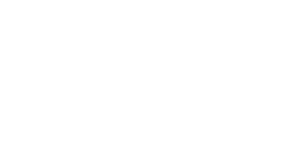

<AxesSubplot:>

In [15]:
import numpy as np
import seaborn as sns

fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(111)
sns.lineplot(data=tst)

<IPython.core.display.Javascript object>


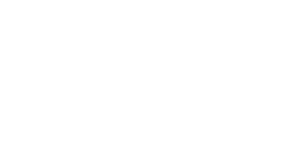

In [16]:
import random
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

# define a and b here
a = tst
b = []
for i in range(21):
    b.append(i+1)

# Helps pick a random color for each plot, used for readability
rand = lambda: random.randint(0, 255)
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(111)
ax.set(ylim=(0.4, 1))
for ydata in a:
    clr = '#%02X%02X%02X' % (rand(),rand(),rand())
    plot, = ax.plot(b, ydata, color=clr, alpha = 0.2)
    sns.boxplot(data=tst)

In [17]:
tst.max()

0.8040761392039992